# Working in a transformed parameter space

This example shows you how to run an optimisation in a transformed parameter space.
(For an introduction to PINTS optimisation, see: [Optimisation: first example](./first-example.ipynb).)

First we will create a toy model, in this case a [logistic model](https://pints.readthedocs.io/en/latest/toy/logistic_model.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.toy as toy

model = toy.LogisticModel()

The parameter vector for the toy logistic model is $\theta_\text{org} = [r, K]$, where $r$ is a growth rate and $K$ is called the carrying capacity.
Because these parameters have very different magnitudes, we will create a wrapper that instead uses the parameter vector $\theta = [r, \log(K)]$

In [2]:
class TransformedModel(pints.ForwardModel):
    def __init__(self, model):
        self._model = model
    
    def n_parameters(self):
        return self._model.n_parameters()
    
    def simulate(self, parameters, times):
        transformed_parameters = [parameters[0], np.exp(parameters[1])]
        return self._model.simulate(transformed_parameters,times)

transformed_model = TransformedModel(model)

Just like the untransformed model, we can use this transformed variant with several PINTS routines.

For example, we can fit it to a synthetic data set using CMA-ES:

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      3.57e+07   0:00.1
1     12     3.57e+07   0:00.1
2     18     3.5e+07    0:00.1
3     24     3.44e+07   0:00.1
20    126    6347837    0:00.1
40    246    100298.1   0:00.2
60    366    98811.86   0:00.3
80    486    98811.85   0:00.3
100   606    98811.85   0:00.4
120   726    98811.85   0:00.4
140   846    98811.85   0:00.5
160   966    98811.85   0:00.5
180   1086   98811.85   0:00.6
200   1206   98811.85   0:00.7
220   1326   98811.85   0:00.7
240   1446   98811.85   0:00.8
260   1566   98811.85   0:00.8
280   1686   98811.85   0:00.9
300   1806   98811.85   0:00.9
320   1926   98811.85   0:01.0
340   2046   98811.85   0:01.0
360   2166   98811.85   0:01.1
361   2166   98811.85   0:01.1
Halting: No significant change for 200 iterations.
Score at true solution: 
99353.56799758377
Found solution:          Tr

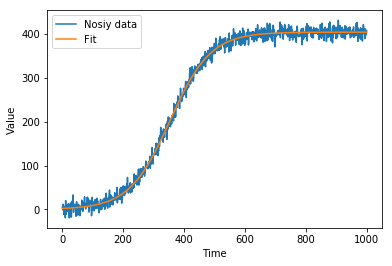

In [3]:
# Create some toy data
real_parameters = [0.015, 6]
times = np.linspace(0, 1000, 1000)
values = transformed_model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(transformed_model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0, -6.0], [0.03, 20.0])

# Perform an optimisation with boundaries and hints
x0 = 0.01,5.0
sigma0 = [0.01, 2.0]
found_parameters, found_value = pints.optimise(
    score,
    x0,
    sigma0,
    boundaries,
    method=pints.CMAES,
)

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

# Show quality of fit
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, values, label='Nosiy data')
plt.plot(times, problem.evaluate(found_parameters), label='Fit')
plt.legend()
plt.show()